# States for MDP 

States from paper

http://www.ijmlc.org/vol5/515-C003.pdf

In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result
from lob_data_utils.svm_calculation import lob_svm
import states

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 10000
stock = '9065'

In [3]:
df, df_test = lob.load_prepared_data(
    stock, data_dir='../queue_imbalance/data/prepared', length=data_length)
df.drop(columns=['bid', 'ask'], inplace=True)

In [4]:
print(len(df))
df.head()

8000


,Unnamed: 0,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2000,2013-09-11 12:46:00,1605.0,1606.0,1605.50,1917.0,11420.0,0.0,0.712529
2001,2013-09-11 12:48:00,1604.5,1605.5,1605.00,4564.0,8561.0,0.0,0.304533
2002,2013-09-11 12:50:00,1604.5,1605.0,1604.75,187.0,9477.0,1.0,0.961300
2003,2013-09-11 12:51:00,1604.5,1605.5,1605.00,7362.0,8320.0,0.0,0.061089
2004,2013-09-11 12:52:00,1604.5,1605.0,1604.75,6991.0,6600.0,1.0,-0.028769


## Introduce states

    state will be bid_price, ask_price, spread, sum_sell_ask, sum_buy_bid, mid_price
    queue imbalance
    TODO: spread does not seem to have any sense!

In [5]:
df = states.add_state(df)
df.head()

,Unnamed: 0,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance,spread,state_ask,state_bid,state_sum_ask,state_sum_bid,state_spread,state_imbalance,state_mid
2000,2013-09-11 12:46:00,1605.0,1606.0,1605.50,1917.0,11420.0,0.0,0.712529,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,2013-09-11 12:48:00,1604.5,1605.5,1605.00,4564.0,8561.0,0.0,0.304533,1.0,-1.0,-1.0,1.0,-1.0,0.0,-1.0,-1.0
2002,2013-09-11 12:50:00,1604.5,1605.0,1604.75,187.0,9477.0,1.0,0.961300,0.5,-1.0,0.0,-1.0,1.0,-1.0,1.0,-1.0
2003,2013-09-11 12:51:00,1604.5,1605.5,1605.00,7362.0,8320.0,0.0,0.061089,1.0,1.0,0.0,1.0,-1.0,1.0,-1.0,1.0
2004,2013-09-11 12:52:00,1604.5,1605.0,1604.75,6991.0,6600.0,1.0,-0.028769,0.5,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0


## Clustering states attempt

In [6]:
df.dropna(inplace=True)
state_labels = [c for c in df.columns if 'state' in c]
dbscan = cluster.DBSCAN()
groups = dbscan.fit_predict(df[state_labels])
df['groups'] = groups

In [7]:
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual, widgets


@interact(num=(-1, len(np.unique(dbscan.labels_)) - 1))
def _plot_lob(num):
    py_config = {'displayModeBar': False, 'showLink': False, 'editable': False}

    data = []
    for i in state_labels:
        data.append(go.Scatter(
            x=df.index, # assign x as the dataframe column 'x'
            y=df[df['groups'] == num][i], name=i, opacity=0.25))
    title='df {}'.format(len(df[df['groups'] == num]))
    layout = go.Layout(
            title = title,
            showlegend = True,
            legend = dict(orientation="h")
        )

    figure = go.Figure(data=data, layout=layout)
    py.iplot(figure, filename='pandas/basic-line-plot', config=py_config)

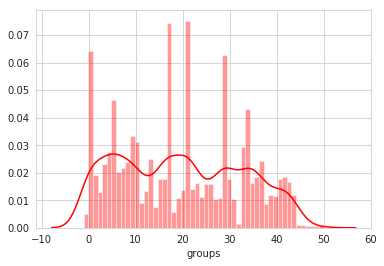

In [8]:
sns.distplot(df['groups'], bins=len(df['groups'].unique()), color='r')

## Let's hash the states



In [9]:
hashes = []
for i, row in df.iterrows():
    hashes.append(states.get_state_number(df, i))
df['hash'] = hashes

In [10]:
df['hash'].head(20)

2001     567
2002    1479
2003     707
2004       3
2005    2183
2006      21
2007    2087
2008      99
2009    2168
2010    1479
2011     707
2012      21
2013     707
2014      61
2015    2125
2016      21
2017     648
2018      99
2019      80
2020    2107
Name: hash, dtype: int64

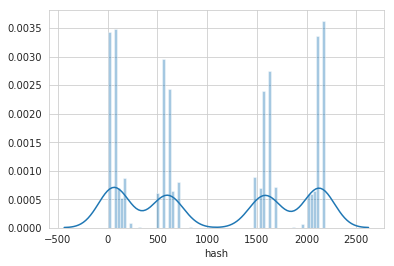

In [11]:
sns.distplot(df['hash'], bins=len(df['hash'].unique()))

In [12]:
df['hash'].unique()

array([ 567, 1479,  707,    3, 2183,   21, 2087,   99, 2168,   61, 2125,
        648,   80, 2107,  486,    0, 2186, 1557, 1538,  649, 2106,  629,
         62, 2105, 1639,  547, 1537, 1638,  548, 1619,   81, 1700,  180,
         79, 2165,  143,   18,  161, 1476, 1697,  489, 2124, 2043,  828,
       2025,  710, 2006,  750, 1882,  224, 1944, 2023,  162,   60, 1965,
        182,  239, 2005,  304, 1947,  242,  181,  163, 2004, 2024, 1800,
       1377, 1962, 2162,  546, 1358,  221])

In [13]:
transitions = np.zeros((max(df['hash'])+1, max(df['hash'] + 1)))
previous_row = None
for i, row in df.iterrows():
    if not np.any(previous_row):
        previous_row = row
        continue
    transitions[row['hash']][previous_row['hash']] += 1
    previous_row = row
    

for j in range(len(transitions)):
    s = np.sum(transitions[j])
    if s == 0:
        continue
    for i in range(len(transitions[j])):
        transitions[j][i] = transitions[j][i]/s

transitions[547][181]

0.0

In [14]:
for j in range(len(transitions)):
    for i in range(len(transitions[i])):
        if transitions[j][i] > 0.5:
            print(j, i, transitions[j][i])

60 2087 1.0
221 1944 1.0
242 2087 0.6
546 2162 1.0
750 99 1.0
1358 486 1.0
1377 80 1.0
1800 1557 1.0
1962 224 1.0
2004 489 1.0
2024 1638 1.0


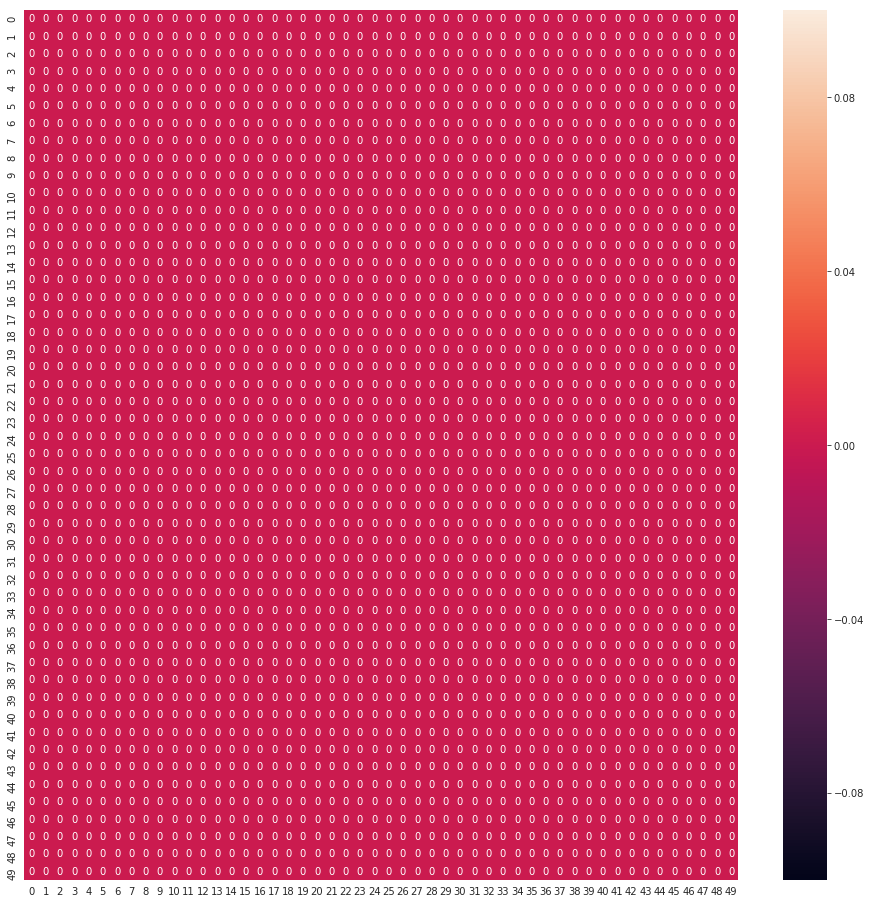

In [15]:
temp = np.zeros((50, 50))
for i in range(len(temp)):
    for j in range(len(temp[i])):
        temp[i][j] = transitions[i][j]
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(temp, annot=True, ax=ax)

In [16]:
for j in range(len(transitions)):
    if np.sum(transitions[j]) < 1 and j in df['hash'].values:
        print(j, np.sum(transitions[j]))


18 0.9999999999999999
21 0.9999999999999999
62 0.9999999999999998
162 0.9999999999999999
547 0.9999999999999999
1639 0.9999999999999999
1944 0.9999999999999999


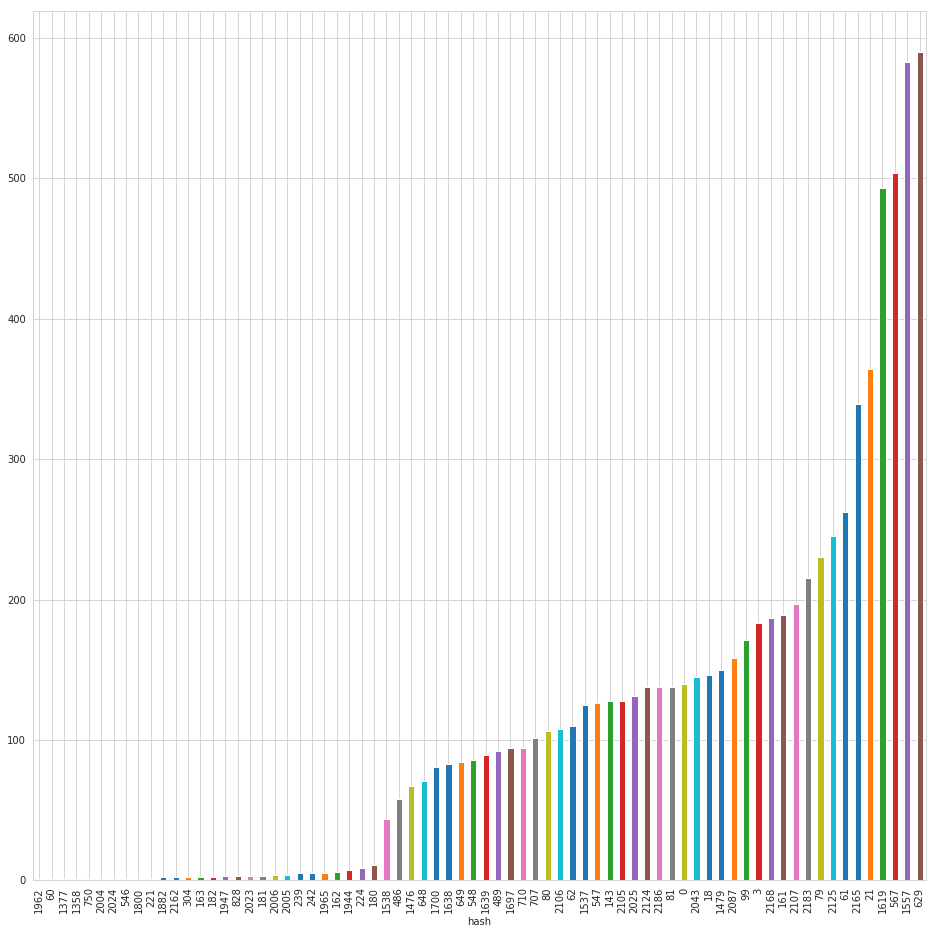

In [17]:
df.groupby(by='hash')['hash'].count().sort_values().plot(kind='bar', figsize=(16, 16))

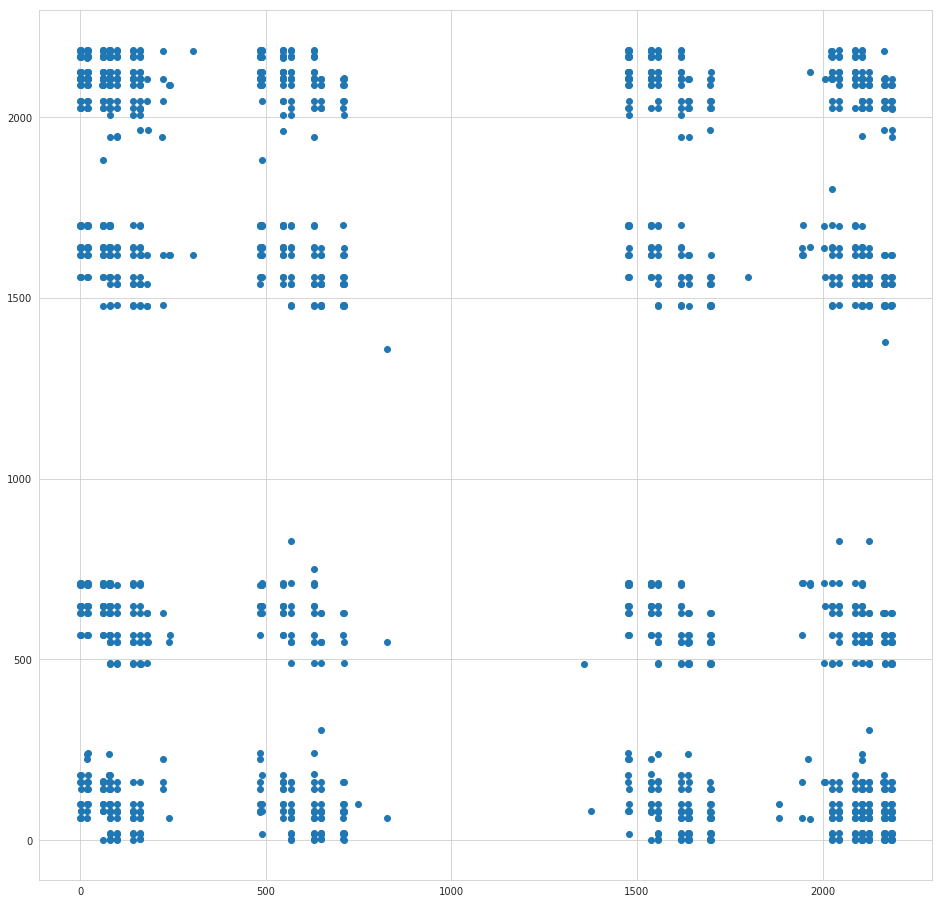

In [18]:
x = []
y = []
for i in range(len(transitions)):
    for j in range(len(transitions)):
        if transitions[i][j] > 0:
            x.append(i)
            y.append(j)
            
plt.figure(figsize=(16,16))
plt.scatter(x, y)

In [42]:
def plot_matrix(m2):
    x = []
    y = []
    for i in range(len(m2.A)):
        for j in range(len(m2.A)):
            if m2.A[i][j] > 0:
                x.append(i)
                y.append(j)

    plt.figure(figsize=(16,16))
    plt.scatter(x, y)

m = np.matrix(transitions)
m2 = np.matmul(transitions, transitions)
plot_matrix(m2)

AttributeError: 'numpy.ndarray' object has no attribute 'A'

In [20]:
df.head()

,Unnamed: 0,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance,spread,state_ask,state_bid,state_sum_ask,state_sum_bid,state_spread,state_imbalance,state_mid,groups,hash
2001,2013-09-11 12:48:00,1604.5,1605.5,1605.00,4564.0,8561.0,0.0,0.304533,1.0,-1.0,-1.0,1.0,-1.0,0.0,-1.0,-1.0,0,567
2002,2013-09-11 12:50:00,1604.5,1605.0,1604.75,187.0,9477.0,1.0,0.961300,0.5,-1.0,0.0,-1.0,1.0,-1.0,1.0,-1.0,1,1479
2003,2013-09-11 12:51:00,1604.5,1605.5,1605.00,7362.0,8320.0,0.0,0.061089,1.0,1.0,0.0,1.0,-1.0,1.0,-1.0,1.0,2,707
2004,2013-09-11 12:52:00,1604.5,1605.0,1604.75,6991.0,6600.0,1.0,-0.028769,0.5,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,3,3
2005,2013-09-11 12:56:00,1604.5,1605.5,1605.00,9406.0,11252.0,0.0,0.089360,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,4,2183


In [21]:
np.argmax(transitions[181])

629

In [22]:
df[list(sorted([c for c in df.columns if 'state' in c]))].head(2)

,state_ask,state_bid,state_imbalance,state_mid,state_spread,state_sum_ask,state_sum_bid
2001,-1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0
2002,-1.0,0.0,1.0,-1.0,-1.0,-1.0,1.0


In [23]:
states.unhash_state(181, sorted([c for c in df.columns if 'state' in c]))

{'state_ask': 0,
 'state_bid': -1,
 'state_imbalance': 1,
 'state_mid': -1,
 'state_spread': 1,
 'state_sum_ask': -1,
 'state_sum_bid': -1}

## Accessibility of states

P - transition matrix

State j is said to be accessible from state i if $P_{ij}^n > 0$ for some $n >= 0$.
Two states i and j that are accessible to each other are said to communicate.

In [24]:
def if_states_communicating(transitions, state1, state2, n=1):
    if n == 1:
        return transitions[state1][state2] > 0 and transitions[state2][state1] > 0
    temp = transitions
    for i in range(n):
        if temp[state1][state2] > 0 and temp[state2][state1] > 0:
            return True
        temp = np.matmul(temp, temp)
    return False

if_states_communicating(transitions, 181, 547, n=1)

False

In [25]:
def get_state_groups(transitions):
    groups = [[i] for i in list(range(len(transitions)))]
    for i in range(len(transitions)):
        for j in range(len(transitions)):
            if if_states_communicating(transitions, i, j):
                groups[i].append(j)
    return groups
        
groups = get_state_groups(transitions)

In [26]:
def get_group_lengths(groups, plot=False):
    groups_lengths = [len(g) for g in groups]
    if plot:
        plt.plot(groups_lengths)
    empty_groups = 0
    for i in range(len(groups_lengths)):
        if groups_lengths[i] <= 1:
            empty_groups += 1
    return empty_groups, len(groups_lengths) - empty_groups

get_group_lengths(groups)

(2138, 49)

In [27]:
def plot_heatmap(transitions, plot_name='transitions.png'):
    hashes = df['hash'].unique()
    transition_states_only = []

    for i in range(len(hashes)):
        for j in range(len(hashes)):
            transition_states_only.append({'i': i, 'j': j, 'val': transitions[hashes[i]][hashes[j]]})
    
    fig, ax = plt.subplots(figsize=(64, 64))
    df_trans = pd.DataFrame(transition_states_only)
    df_trans = df_trans.pivot('i', 'j', 'val')
    sns.heatmap(df_trans, annot=True, ax=ax)
    plt.savefig(plot_name)
    return df_trans

(2115, 72)

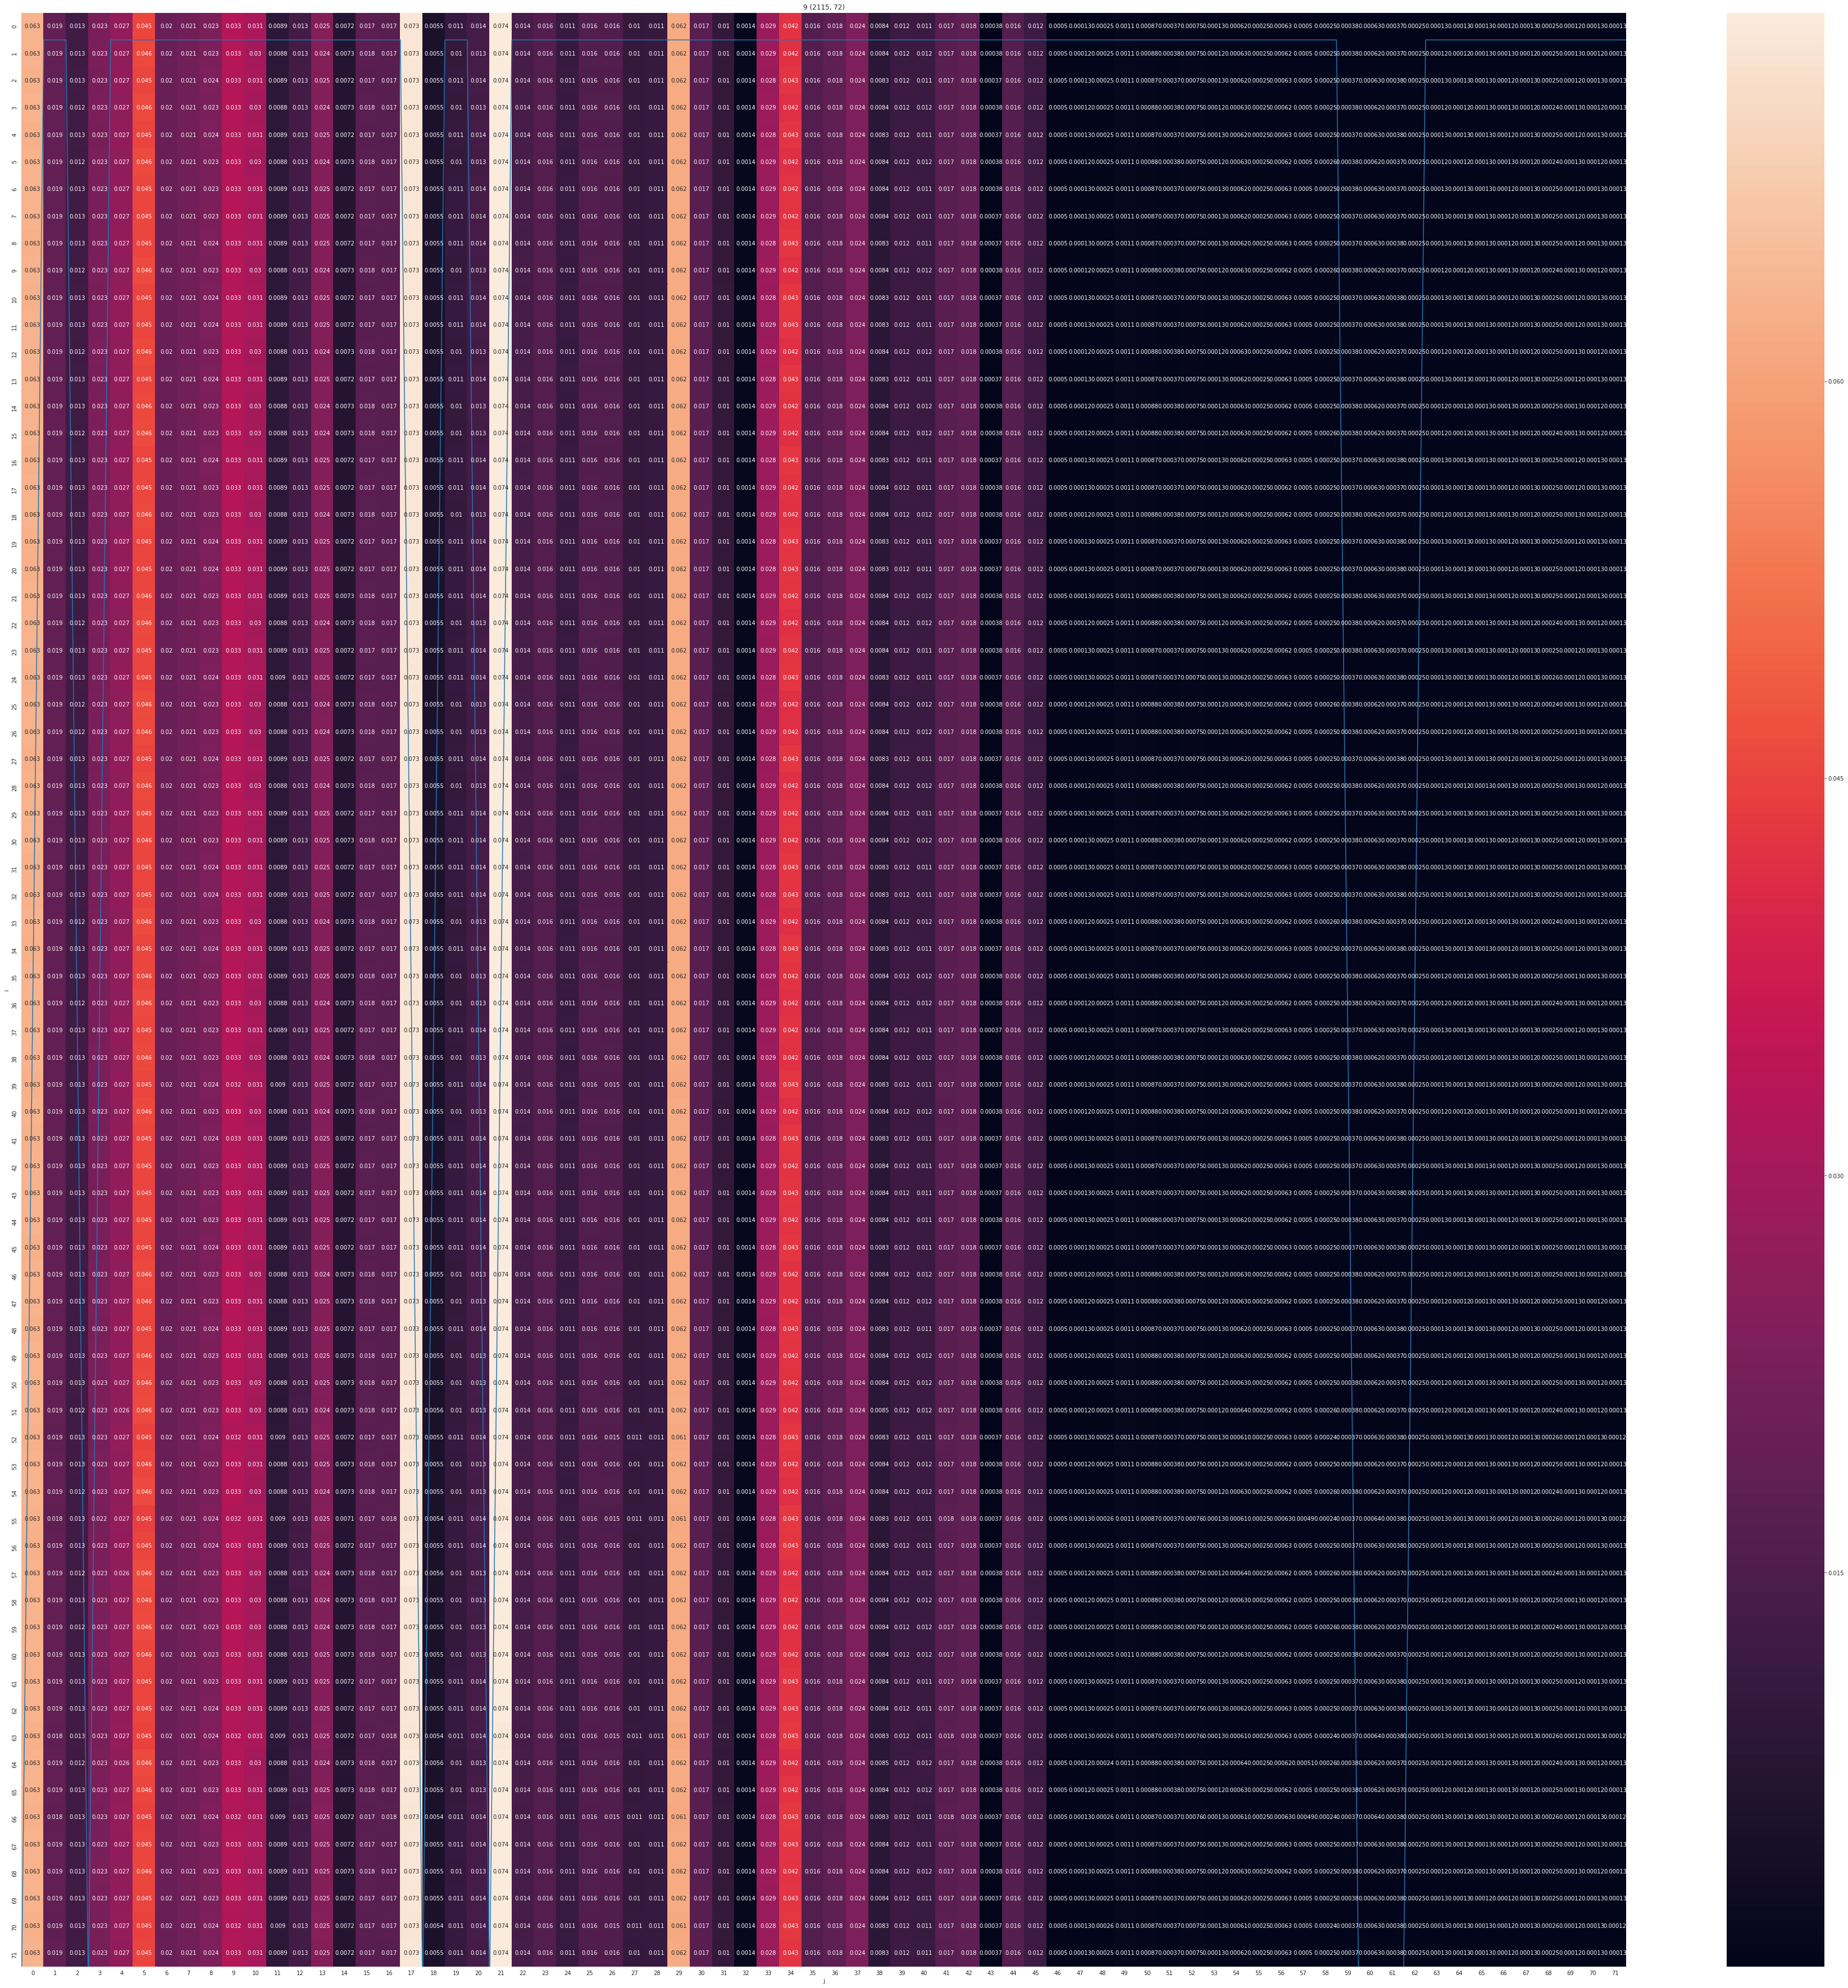

In [37]:
temp = np.matmul(transitions, transitions)
for i in range(2, 10):
    groups2 = get_state_groups(temp)
    g = get_group_lengths(groups2)
    temp = np.matmul(temp, transitions)
plot_heatmap(temp, plot_name='plots/transitions_{}_{}.png'.format(stock, i))
plt.title('{} {}'.format(i, g))
get_group_lengths(groups2, plot=True)

